In [76]:
import sys
import numpy as np
import matplotlib.pyplot as plt 

np.random.seed(0)

In [77]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [78]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# -----------------------------
# Load Data
# -----------------------------
path_to_data = "ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl"

with open(path_to_data, "rb") as f:
    train_data = pickle.load(f)



X = train_data["images"].astype("float32") / 255.0
y = train_data["labels"].reshape(-1)

X = X.astype(np.float32)
X = (X - X.min()) / (X.max() - X.min() + 1e-6)

X = (X - X.mean()) / (X.std() + 1e-6)


# -----------------------------
# Train/Val Split
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# One-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes=5)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])
# -----------------------------
# Model Definition
# -----------------------------
def create_cnn_model(num_classes=5, data_augmentation=data_augmentation):
    model = models.Sequential([

        layers.Input(shape=(28, 28, 3)),
        data_augmentation,


        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model


model = create_cnn_model(5)


# -----------------------------
# Class Weights
# -----------------------------
classes = np.unique(y_train)
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)


# -----------------------------
# Compile
# -----------------------------
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall")
    ]
)


# -----------------------------
# TRAINING
# -----------------------------
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=45,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=12,
            restore_best_weights=True,
            mode="min"
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            mode="min",
            min_lr=1e-6
        )
    ],
    shuffle=True
)


# -----------------------------
# Evaluation
# -----------------------------
from sklearn.metrics import classification_report, balanced_accuracy_score

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred_classes))
print(classification_report(y_val, y_pred_classes))



Class weights: {np.uint8(0): np.float64(0.4442159383033419), np.uint8(1): np.float64(1.6941176470588235), np.uint8(2): np.float64(1.0472727272727274), np.uint8(3): np.float64(1.1148387096774193), np.uint8(4): np.float64(3.260377358490566)}
Epoch 1/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2153 - loss: 2.5535 - recall: 0.1470 - val_accuracy: 0.3981 - val_loss: 1.5395 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2708 - loss: 2.2035 - recall: 0.1933 - val_accuracy: 0.1343 - val_loss: 1.6568 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2789 - loss: 2.1656 - recall: 0.1736 - val_accuracy: 0.2315 - val_loss: 1.6187 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3009 - loss: 1.9681 - recall: 0.1956 - val_accuracy: 0.2546 - val_loss: 1.6103 - val_recall: 0.0093 - learning_rate:

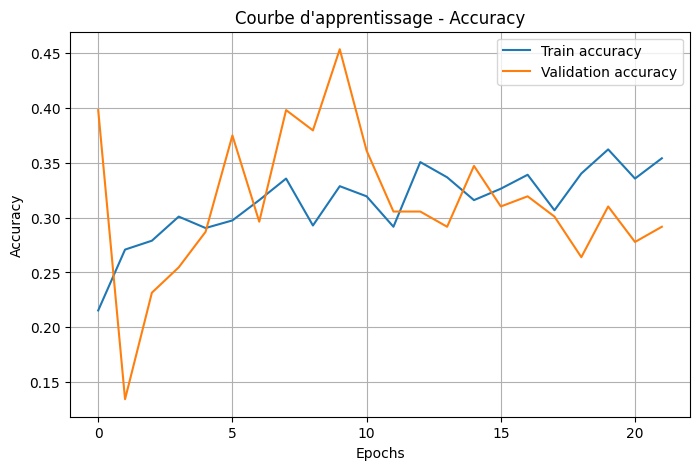

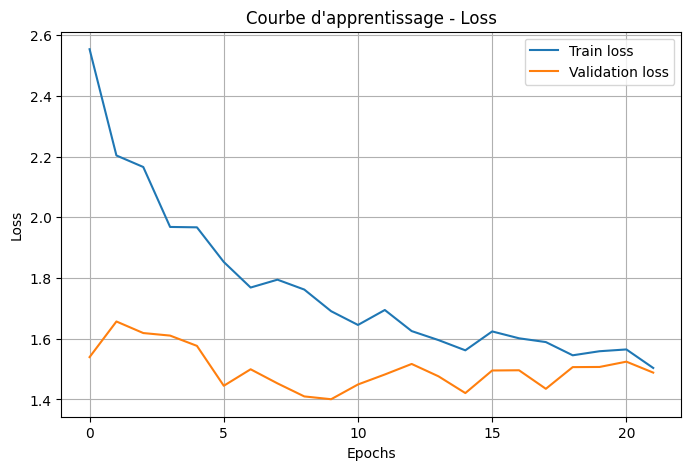

In [79]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe d'apprentissage - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe d'apprentissage - Loss")
plt.legend()
plt.grid(True)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


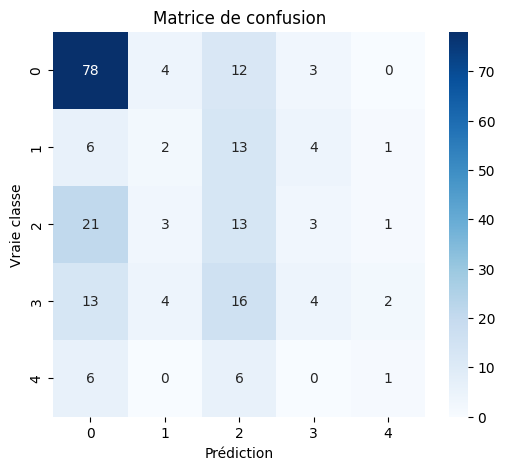

Recall par classe : [0.80412371 0.07692308 0.31707317 0.1025641  0.07692308]
acc: 0.4537037037037037
Recall macro : 0.275521427696434


In [80]:
y_val_pred = model.predict(X_val)
y_val_pred_classes = y_val_pred.argmax(axis=1)
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_val, y_val_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.show()
from sklearn.metrics import recall_score

recall_per_class = recall_score(y_val, y_val_pred_classes, average=None)
recall_macro = recall_score(y_val, y_val_pred_classes, average="macro")
acc = accuracy_score(y_val, y_val_pred_classes)
print("Recall par classe :", recall_per_class)
print('acc:', acc)
print("Recall macro :", recall_macro)


In [81]:
import pickle
import numpy as np
import pandas as pd
"""
# --------------------------
# 1. Charger le modèle entraîné
# --------------------------
model, scaler = pickle.load(open("model_softmax.pkl", "rb"))

# --------------------------
# 2. Charger le test_data.pkl
# --------------------------
with open("ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

X_test_imgs = test_data["images"]


# Apply to test set
X_test_feats = np.array([extract_features(img) for img in X_test_imgs], dtype=np.float32)

# --------------------------
# 4. Normaliser avec les stats du train
# --------------------------
X_test_norm = scaler.transform(X_test_feats)

# --------------------------
# 5. Prédire
# --------------------------
y_pred = model.compute_output(X_test_norm).astype(int)

# --------------------------
# 6. Générer le CSV Kaggle
# --------------------------
df = pd.DataFrame({
    "ID": np.arange(1, len(y_pred)+1),
    "Label": y_pred
})

df.to_csv("ift3395_YamirPoldoSilvaV7.csv", index=False)

print("Fichier 'submission.csv' généré !")
"""


'\n# --------------------------\n# 1. Charger le modèle entraîné\n# --------------------------\nmodel, scaler = pickle.load(open("model_softmax.pkl", "rb"))\n\n# --------------------------\n# 2. Charger le test_data.pkl\n# --------------------------\nwith open("ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl", "rb") as f:\n    test_data = pickle.load(f)\n\nX_test_imgs = test_data["images"]\n\n\n# Apply to test set\nX_test_feats = np.array([extract_features(img) for img in X_test_imgs], dtype=np.float32)\n\n# --------------------------\n# 4. Normaliser avec les stats du train\n# --------------------------\nX_test_norm = scaler.transform(X_test_feats)\n\n# --------------------------\n# 5. Prédire\n# --------------------------\ny_pred = model.compute_output(X_test_norm).astype(int)\n\n# --------------------------\n# 6. Générer le CSV Kaggle\n# --------------------------\ndf = pd.DataFrame({\n    "ID": np.arange(1, len(y_pred)+1),\n    "Label": y_pred\n})\n\ndf.to_csv("ift3395_Y